In [1]:
import pathlib

import astropy.table as at
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm

import arviz as az
from aesara_theano_fallback import tensor as tt
import pymc3 as pm
import pymc3_ext as pmx

from hq.config import Config

In [2]:
allstar_path = pathlib.Path('~/data/APOGEE_DR17/allStar-dr17-synspec.fits')
allstar_path = allstar_path.expanduser().resolve()
assert allstar_path.exists()

In [3]:
hq_run_path = pathlib.Path('~/projects/apogee-dr17-binaries/')
hq_run_path = hq_run_path.expanduser().resolve()

hq_config_path = hq_run_path / 'hq-config/config.yml'
hq_cache_path = hq_run_path / 'cache/hq'
assert hq_config_path.exists()

In [4]:
allstar = at.QTable.read(allstar_path)

In [5]:
c = Config(hq_config_path)

In [6]:
metadata = at.QTable.read(hq_cache_path / 'metadata.fits')
metadata = at.join(metadata, allstar, keys='APOGEE_ID')
metadata = at.unique(metadata, keys='APOGEE_ID')
len(metadata)

358350

In [7]:
llr_const = metadata['max_unmarginalized_ln_likelihood'] - metadata['robust_constant_ln_likelihood']

In [8]:
binaries_mask = (
    (llr_const > 5) & 
    (metadata['max_unmarginalized_ln_likelihood'] > -6)
)
binaries_mask.sum()

58743

In [13]:
def get_fit_data(mask, logg_bins=None):
    if logg_bins is None:
        logg_bins = np.arange(-0.25, 5.5, 0.05)
    
    logg_binc = 0.5 * (logg_bins[:-1] + logg_bins[1:])
    
    H_bin, _ = np.histogram(metadata['LOGG'][binaries_mask & mask], 
                            bins=logg_bins)
    H_all, _ = np.histogram(metadata['LOGG'][mask], 
                            bins=logg_bins)
    
    # TODO: can use math to do this instead, lazy 
    ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) / 
             np.random.poisson(H_all, size=(1_000, len(H_all))))

    data_x = logg_binc
    data_y = np.mean(ratio, axis=0)
    data_yerr = np.std(ratio, axis=0)

    sort_idx = np.argsort(data_x)
    data_x = data_x[sort_idx]
    data_y = data_y[sort_idx]
    data_yerr = data_yerr[sort_idx]

    good_idx = np.isfinite(data_y)
    data_x = data_x[good_idx]
    data_y = data_y[good_idx]
    data_yerr = data_yerr[good_idx]
    
    return data_x, data_y, data_yerr

In [14]:
mh_mask = metadata['M_H'] > -1.
data_x, data_y, data_yerr = get_fit_data(mh_mask)

<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /


Text(0, 0.5, 'obs. binary fraction')

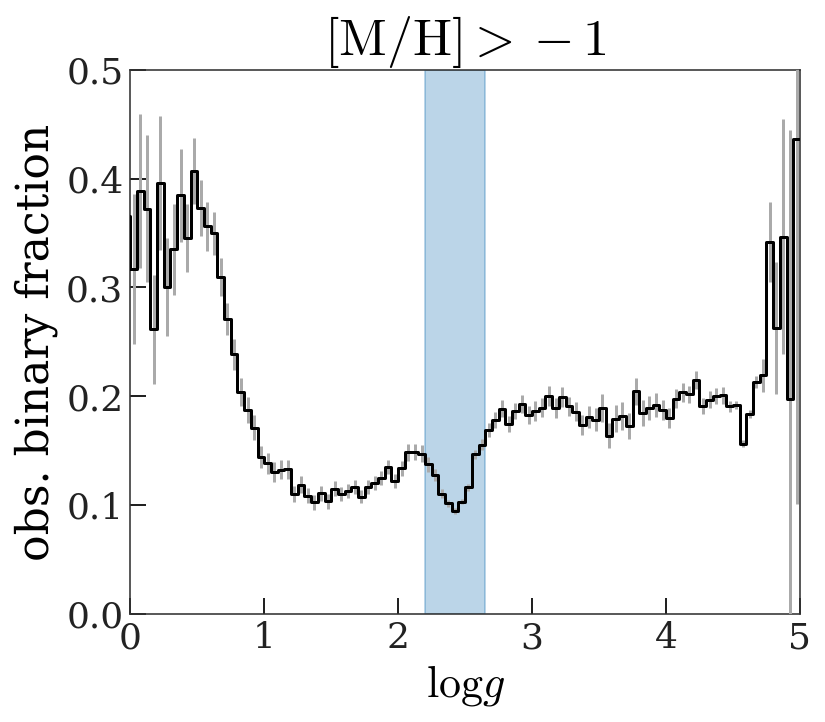

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(data_x,
        data_y,
        marker='', drawstyle='steps-mid', zorder=10)

ax.errorbar(data_x,
            data_y,
            data_yerr,
            ecolor='#aaaaaa', ls='none', marker='', zorder=5)

ax.set_title(r'$[{\rm M}/{\rm H}] > -1$')
ax.set_xlim(0., 4.5)
ax.set_ylim(0, 0.5)
ax.set_xlabel(r'$\log g$')

ax.set_xticks(np.arange(0, 5+1, 1))

ax.axvspan(2.2, 2.65, color='tab:blue', alpha=0.3)

ax.set_ylabel('obs. binary fraction')

In [16]:
fit_idx = (
    (data_x > 1.4) &
    np.logical_not((data_x > 2.2) & (data_x < 2.65)) &
    (data_x < 4.5)
)
fit_x = data_x[fit_idx]
fit_y = data_y[fit_idx]
fit_yerr = data_yerr[fit_idx]

In [53]:
def get_samples(x, y, yerr):
    with pm.Model() as model:    
        break_x = pm.Uniform('break_x', 2.5, 4)
        const_y = pm.Uniform('const_y', 0., 0.6)
        slope = pm.Uniform('slope', 1e-4, 1)

        model_y = tt.where(x < break_x, 
                           slope * (x - break_x) + const_y, 
                           const_y)
        lnlike = pm.Normal('lnlike', mu=model_y, sd=yerr, observed=y)

        res = pmx.optimize(start={
            'break_x': 2.8,
            'const_y': 0.18,
            'slope': 0.02
        })

        samples = pmx.sample(start=res, return_inferencedata=True)
    
    return samples

In [31]:
samples = get_samples(fit_x, fit_y, fit_yerr)

optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -128.1316297060385 -> 172.04805528519304


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [19]:
def get_model_y(x, res, subN=None, rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=42)
        
    if isinstance(res, dict):
        model_y = np.where(x < res['break_x'],
                           res['slope'] * (x - res['break_x']) + res['const_y'],
                           res['const_y'])
        return model_y
    
    elif isinstance(res, az.InferenceData):
        size = res.posterior.draw.size * res.posterior.chain.size
        samples = {k: res.posterior.get(k).values.ravel() 
                   for k in res.posterior.data_vars}
        
        if subN is not None:
            idx = rng.choice(size, size=subN, replace=False)
        else:
            idx = np.arange(size)
        
        if len(idx) > 1000:
            raise NotImplementedError()
            
        all_model_y = []
        for i in idx:
            model_y = get_model_y(x, {k: samples[k][i] for k in samples.keys()})
            all_model_y.append(model_y)
        
        return np.array(all_model_y)

In [41]:
min_idx = np.abs(data_x - 2.4).argmin()
# min_idx = np.where((data_x > 2) & (data_x < 3))[0]
# min_idx = min_idx[np.argmin(data_y[min_idx])]
print(data_x[min_idx])
data_y[min_idx], data_yerr[min_idx]

2.4000000000000004


(0.0997587544233861, 0.005896930175180688)

In [42]:
tmp = get_model_y(data_x[min_idx], samples, subN=512)
pred_min_y = np.mean(tmp)
pred_min_yerr = np.std(tmp)
pred_min_y, pred_min_yerr

(0.15698270398828973, 0.0019235255932215022)

Text(0, 0.5, 'obs. binary fraction')

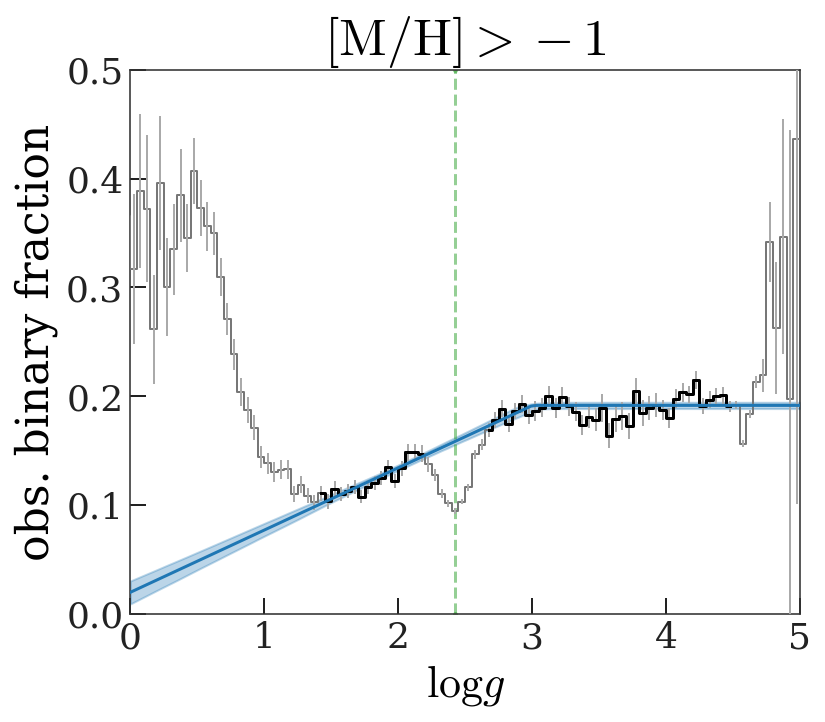

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(data_x,
        data_y,
        marker='', drawstyle='steps-mid', zorder=10,
        color='#777777', linewidth=1)

_idx = np.concatenate(([0], np.where(np.diff(fit_x) > 0.1)[0]+1, [len(fit_x)]))
for i1, i2 in zip(_idx[:-1], _idx[1:]):
    ax.plot(fit_x[i1:i2],
            fit_y[i1:i2],
            marker='', drawstyle='steps-mid', color='k', zorder=100)
    
ax.errorbar(data_x,
            data_y,
            data_yerr,
            ecolor='#aaaaaa', ls='none', marker='', zorder=100, elinewidth=1)

grid_x = np.linspace(0, 5, 128)
plt.plot(grid_x, get_model_y(grid_x, res), 
         marker='', color='tab:blue', zorder=200, ls='-')

pcl1, pcl2 = np.percentile(get_model_y(grid_x, samples, subN=512),
                           q=[5, 95], axis=0)
plt.fill_between(grid_x, pcl1, pcl2, color='tab:blue', alpha=0.3)
# plt.plot(grid_x, get_model_y(grid_x, samples, subN=512).T, 
#          marker='', color='tab:blue', alpha=0.1)

ax.set_title(r'$[{\rm M}/{\rm H}] > -1$')
ax.set_xlim(0., 4.5)
ax.set_ylim(0, 0.5)
ax.set_xlabel(r'$\log g$')

ax.set_xticks(np.arange(0, 5+1, 1))

ax.axvline(data_x[min_idx], color='tab:green', linestyle='--', alpha=0.5)

ax.set_ylabel('obs. binary fraction')

## Fit in bins of metallicity?

In [67]:
mh_bin_centers = np.linspace(-1.8, 0.5, 8)
d_mh = mh_bin_centers[1] - mh_bin_centers[0]

rows = []

for i, mh in enumerate(mh_bin_centers):
    row = {}
    row['mh'] = mh
    row['mh_mask'] = np.abs(metadata['M_H'] - mh) < d_mh
    
    if (binaries_mask & mh_mask).sum() < 10_000:
        row['logg_bins'] = np.arange(-0.25, 5.5, 0.1)
    else:
        row['logg_bins'] = np.arange(-0.25, 5.5, 0.05)
    
    row['data_x'], row['data_y'], row['data_yerr'] = get_fit_data(
        row['mh_mask'], logg_bins=logg_bins)
    fit_idx = (
        (row['data_x'] > 1.4) &
        np.logical_not((row['data_x'] > 2.2) & (row['data_x'] < 2.65)) &
        (row['data_x'] < 4.5)
    )
    row['fit_x'] = row['data_x'][fit_idx]
    row['fit_y'] = row['data_y'][fit_idx]
    row['fit_yerr'] = row['data_yerr'][fit_idx]
    
    row['mh_samples'] = get_samples(row['fit_x'], row['fit_y'], row['fit_yerr'])
    
    min_idx = np.abs(row['data_x'] - 2.4).argmin()
    tmp = get_model_y(row['data_x'][min_idx], row['mh_samples'], subN=512)
    
    row['data_y_min'] = row['data_y'][min_idx]
    row['data_y_min_err'] = row['data_yerr'][min_idx]
    row['pred_y_min'] = np.mean(tmp)
    row['pred_y_min_err'] = np.std(tmp)
    
    rows.append(row)

<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
/mnt/home/apricewhelan/anaconda3/envs/dr17-binaries/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -4.4300233415837384 -> 10.612900321777776


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.9612371745376882, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
/mnt/home/apricewhelan/anaconda3/envs/dr17-binaries/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -6.1846453594438175 -> 22.569698258103756


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.9607474795041833, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -5.792614454773846 -> 36.90804827005646


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.9624474202228954, but should be close to 0.9. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6533090901613148, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
optimizing logp for variables: [slope, const_y, brea

message: Desired error not necessarily achieved due to precision loss.
logp: -22.446596011236856 -> 67.382291906802


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
optimizing logp for variables: [slope, const_y, break_x]


message: Desired error not necessarily achieved due to precision loss.
logp: -121.5857008277439 -> 79.61518960396015


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
/mnt/home/apricewhelan/anaconda3/envs/dr17-binaries/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -198.42015240629357 -> 80.99767773637878


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
optimizing logp for variables: [slope, const_y, break_x]


message: Desired error not necessarily achieved due to precision loss.
logp: -51.61922681229196 -> 85.55031275495843


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
<ipython-input-13-80301e3a48b2>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) /
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: 40.30836802475176 -> 69.15651686398857


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.9597183204587546, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


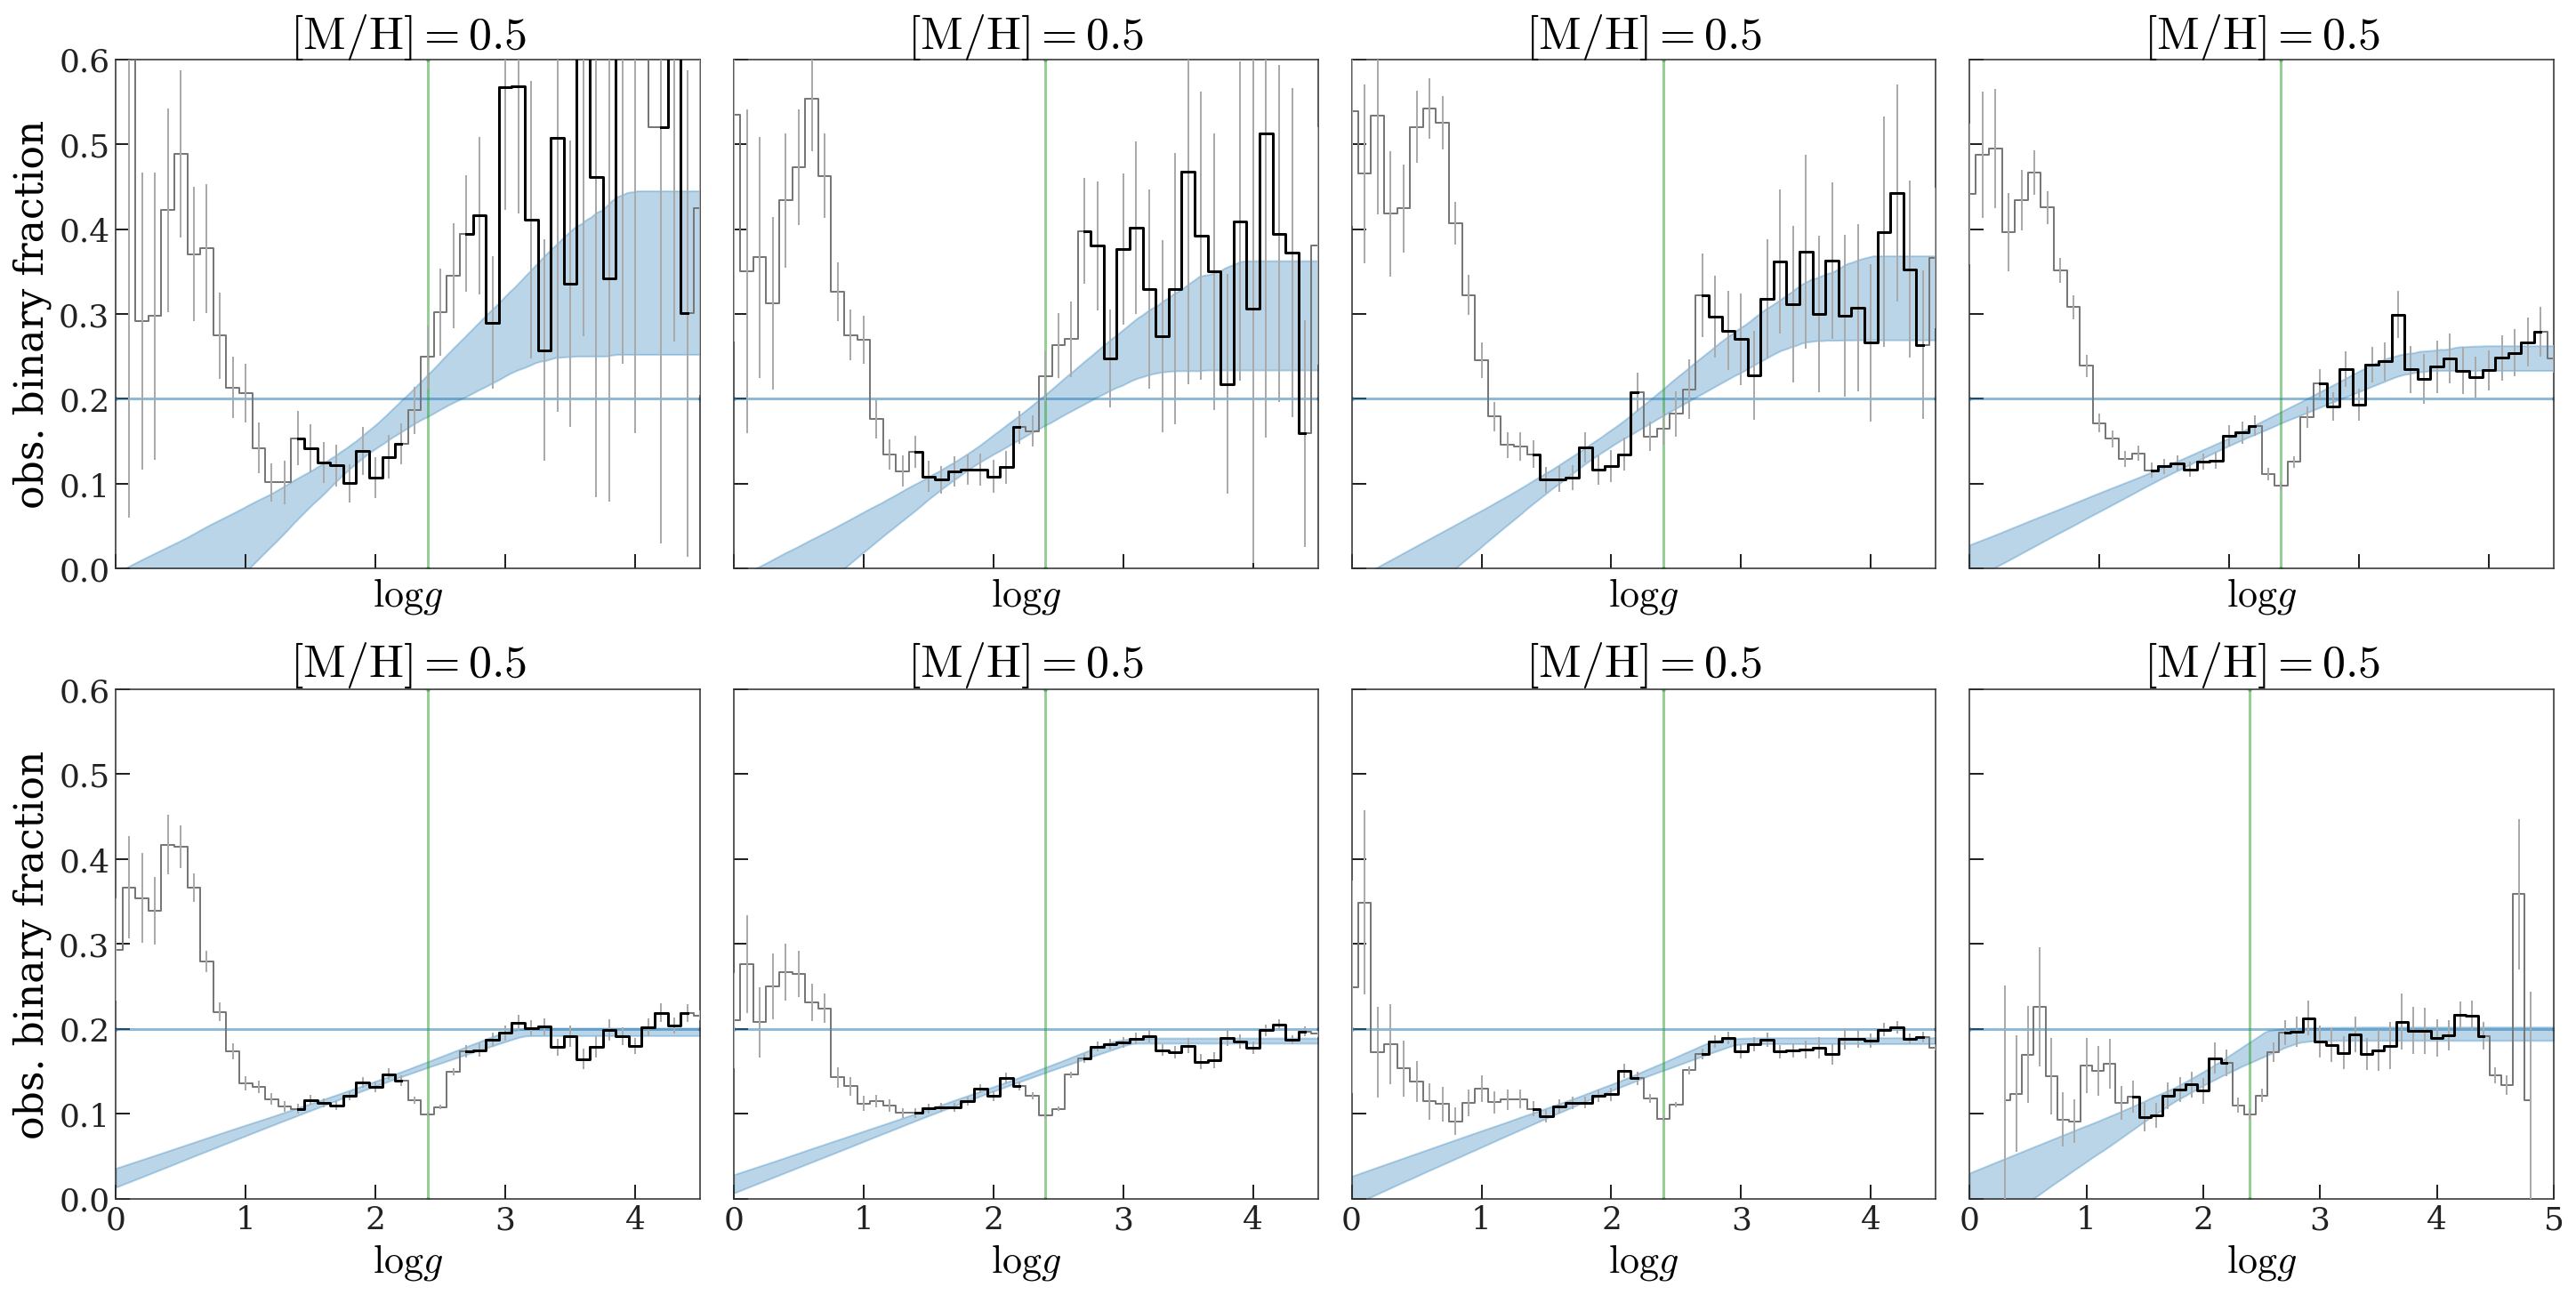

In [70]:
fig, axes = plt.subplots(2, 4, 
                         figsize=(4 * 5, 2 * 5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for i, r in enumerate(rows):
    ax = axes.flat[i]
    
#     ax.plot(r['fit_x'],
#             r['fit_y'],
#             marker='', drawstyle='steps-mid', color='k', zorder=100)
    
    _idx = np.concatenate(([0], np.where(np.diff(r['fit_x']) > 0.15)[0]+1, [len(r['fit_x'])]))
    for i1, i2 in zip(_idx[:-1], _idx[1:]):
        ax.plot(r['fit_x'][i1:i2],
                r['fit_y'][i1:i2],
                marker='', drawstyle='steps-mid', color='k', zorder=100)
    
    ax.plot(r['data_x'],
            r['data_y'],
            marker='', drawstyle='steps-mid', zorder=10,
            color='#777777', linewidth=1)
    
    ax.errorbar(r['data_x'],
                r['data_y'],
                r['data_yerr'],
                ecolor='#aaaaaa', ls='none', marker='', zorder=100, elinewidth=1)
    
    grid_x = np.linspace(0, 5, 128)
    pcl1, pcl2 = np.percentile(get_model_y(grid_x, r['mh_samples'], subN=512),
                               q=[5, 95], axis=0)
    ax.fill_between(grid_x, pcl1, pcl2, color='tab:blue', alpha=0.3)
    
    ax.set_title(r'$[{\rm M}/{\rm H}] = ' + f'{mh:.1f}$')
    ax.set_xlim(0., 4.5)
    ax.set_ylim(0, 0.6)
    ax.set_xlabel(r'$\log g$')
    
    ax.axhline(0.2, color='tab:blue', alpha=0.5)
    ax.axvline(2.4, color='tab:green', alpha=0.5)

ax.set_xticks(np.arange(0, 5+1, 1))

for ax in axes[:, 0]:
    ax.set_ylabel('obs. binary fraction')

In [71]:
for i, r in enumerate(rows):
    print(f"M/H = {r['mh']:.2f}")
    print(f"Data at red clump: {r['data_y_min']:.3f} +/- {r['data_y_min_err']:.3f}")
    print(f"Model prediction: {r['pred_y_min']:.3f} +/- {r['pred_y_min_err']:.3f}")
    print(f"Difference: {r['pred_y_min'] - r['data_y_min']:.3f} +/- {np.sqrt(r['pred_y_min_err']**2 + r['data_y_min_err']**2):.3f}")
    print()

M/H = -1.80
Data at red clump: 0.249 +/- 0.037
Model prediction: 0.203 +/- 0.015
Difference: -0.047 +/- 0.040

M/H = -1.47
Data at red clump: 0.227 +/- 0.029
Model prediction: 0.188 +/- 0.011
Difference: -0.039 +/- 0.031

M/H = -1.14
Data at red clump: 0.165 +/- 0.019
Model prediction: 0.196 +/- 0.009
Difference: 0.031 +/- 0.021

M/H = -0.81
Data at red clump: 0.098 +/- 0.005
Model prediction: 0.178 +/- 0.004
Difference: 0.080 +/- 0.007

M/H = -0.49
Data at red clump: 0.099 +/- 0.003
Model prediction: 0.158 +/- 0.002
Difference: 0.058 +/- 0.003

M/H = -0.16
Data at red clump: 0.098 +/- 0.002
Model prediction: 0.151 +/- 0.002
Difference: 0.054 +/- 0.003

M/H = 0.17
Data at red clump: 0.094 +/- 0.003
Model prediction: 0.156 +/- 0.003
Difference: 0.061 +/- 0.004

M/H = 0.50
Data at red clump: 0.099 +/- 0.006
Model prediction: 0.172 +/- 0.008
Difference: 0.072 +/- 0.010

